In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-ed5d6ee6-3075-49ab-ba6b-ea35ce51e723-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20})

In [3]:
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated


class State(TypedDict):
    query: Annotated[list, add_messages]
    research: Annotated[list, add_messages]
    content: str
    content_ready: bool
    iteration_count: int  # Counter for iterations

# Initialize the StateGraph
graph = StateGraph(State)

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

class ResearchAgent:
    def __init__(self):
        pass

    def format_search(self, query: str) -> str:
        prompt = (
            f"""Você é o cara mais expert do mundo em criação de queries para pesquisas no Google.
            Sua tarefa é pegar uma query de um usuário e retornar uma versão otimizada da mesma. 
            Por favor, não inclua texto extra nem suas explicações, apenas a query otimizada para busca.
            Irei te mostrar alguns exemplos, eles estarão separados por `` ``
            Um exemplo:
            ``
            Original: Quantos grammys a cantora Adele ganhou em toda a carreira dela?
            Otimizado: Quantidade total de Grammys da cantora Adele``
            Outro exemplo:
            ``
            ``
            Original: Treinamento de modelo
            Otimizado: Como treinar modelos de machine learning com sklearn
            ``
            Agora, otimize essa query a seguir:
            Original: {query}
            Otimizada:
            """
        )

        response = llm.invoke(prompt)
        return response.content

    def search(self, state: State):

        search = TavilySearchResults(max_results=2)

        optimized_query = self.format_search(state.get('query', "")[-1].content)
        results = search.invoke(optimized_query)
        return {"research": [results[0]["content"]]}

In [5]:
class EditorAgent:
    def __init__(self):
        pass

    def evaluate_research(self, state:State):
        query = '\n'.join(message.content for message in state.get("query"))
        print(f"Query/queries:{query}")
        print("-"*20)

        research = '\n'.join(message.content for message in state.get("research"))
        print(f"Research Content: {research}")
        print("-"*20)

        iteration_count = state.get("iteration_count", 1)

        if iteration_count is None:
            iteration_count = 1

        print(f"Iteration n.: {iteration_count}")
        print("-"*20)

        if iteration_count >= 3:
            return {"content_ready": True}
        
        prompt = (
            f""""You are an expert editor. Your task is to evaluate the research based on the query. "
            "If the information is sufficient to create a comprehensive and accurate blog post, respond with 'sufficient'. "
            "If the information is not sufficient, respond with 'insufficient' and provide a new, creative query suggestion to improve the results. "
            "If the research results appear repetitive or not diverse enough, think about a very different kind of question that could yield more varied and relevant information. "
            "Consider the depth, relevance, and completeness of the information when making your decision.\n\n"
            "Example 1:\n"
            "Used queries: What are the benefits of a Mediterranean diet?\n"
            "Research: The Mediterranean diet includes fruits, vegetables, whole grains, and healthy fats.\n"
            "Evaluation: Insufficient\n"
            "New query: Detailed health benefits of a Mediterranean diet\n\n"
            "Example 2:\n"
            "Used queries: How does solar power work?\n"
            "Research: Solar power works by converting sunlight into electricity using photovoltaic cells.\n"
            "Evaluation: Sufficient\n\n"
            "Example 3:\n"
            "Used queries: Effects of climate change on polar bears?\n"
            "Research: Climate change is reducing sea ice, affecting polar bear habitats.\n"
            "Evaluation: Insufficient\n"
            "New query: How are polar bears adapting to the loss of sea ice due to climate change?\n\n"
            "Now evaluate the following:\n"
            f"Used queries: {query}\n"
            f"Research: {research}\n\n"
            "Evaluation (sufficient/insufficient):\n"
            "New query (if insufficient):"
            """
        )
        response = llm.invoke(prompt)
        evaluation = response.content.strip()
        
        # Display the evaluation result for debugging purposes
        print(f"Eval: {evaluation}")
        print("-"*20)
        
        # Check if a new query is suggested in the evaluation
        if "new query:" in evaluation.lower():
            new_query = evaluation.split("New query:", 1)[-1].strip()
            return {"query": [new_query], "iteration_count": iteration_count + 1}
        else:
            return {"content_ready": True}


In [6]:
class WriterAgent:
    def __init__(self):
        pass
    
    def write_blogpost(self, state: State):
        # Extract the original query from the state
        query = state.get("query")[0].content
        # Combine all research content into a single string
        research = '\n'.join(message.content for message in state.get("research"))
        
        # Prepare the prompt for the language model to write the blog post
        prompt = (
            "You are an expert blog post writer. Your task is to take a given query and context, and write a comprehensive, engaging, and informative short blog post about it. "
            "Make sure to include an introduction, main body with detailed information, and a conclusion. Use a friendly and accessible tone, and ensure the content is well-structured and easy to read.\n\n"
            f"Query: {query}\n\n"
            f"Context:\n{research}\n\n"
            "Write a detailed and engaging blog post based on the above query and context."
        )
        
        # Invoke the language model with the prompt to generate the blog post
        response = llm.invoke(prompt)
        
        # Return the generated content
        return {"content": response.content}

In [7]:
class TraductorAgent:
    def __init__(self):
        pass

    def traductor_agent(self, state:State):
        content = state.get('content')
        query = state.get('query')

        prompt = (
            f"""You are a expert translator, and your task is identify what is the query language of the user, and translate the response content to,
            Example:
            ``query: Quantos anos tem Rosalia?
            response: Actualmente, la cantante Rosalía es mayor de edad.
            translation: Atualmente, a cantora Rosalía é adulta.
            ``
            ``query: What was Adele's latest album?
            response: O último álbum da cantora Adele foi o 30.
            translation: Adele's latest album was 30.
            ``
            Faça isso para a nova query:
            'query':\n{query}
            'response':\n{content}
            'translation: '"""
        )

        response = llm.invoke(prompt)
        print(f"Translated response: {response.content} ")
        
        return {"content": response.content}
    


In [8]:
from langgraph.graph import END

graph.add_node("search_agent", ResearchAgent().search)
graph.add_node("writer_agent", WriterAgent().write_blogpost)
graph.add_node("editor_agent", EditorAgent().evaluate_research)
graph.add_node("traductor_agent", TraductorAgent().traductor_agent)

In [9]:
graph.set_entry_point("search_agent")
graph.add_edge("search_agent", "editor_agent")
graph.add_conditional_edges(
    "editor_agent",
    lambda state: "accept" if state.get("content_ready") else "revise",
    {
        "accept": "writer_agent", # If content is ready, proceed to writer_agent
        "revise": "search_agent" # If content is not ready, go back to search_agent
    }
)
graph.add_edge("writer_agent", "traductor_agent")
graph.add_edge("traductor_agent",END)
graph = graph.compile()

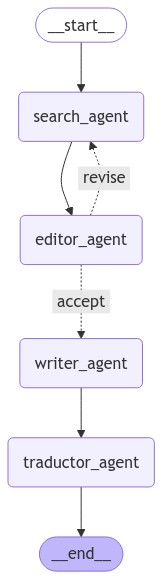

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
blogpost = graph.invoke({"query":"¿Cuántos Grammy tiene Adele en su estantería?"})


Query/queries:¿Cuántos Grammy tiene Adele en su estantería?
--------------------
Research Content: Grammy Awards: Adele has won multiple Grammy Awards, including Album of the Year for "21" and "25," as well as Record of the Year and Song of the Year for songs like "Rolling in the Deep" and "Hello."
--------------------
Iteration n.: 1
--------------------
Eval: Evaluation: Sufficient

New query: N/A
--------------------
Query/queries:¿Cuántos Grammy tiene Adele en su estantería?
N/A
--------------------
Research Content: Grammy Awards: Adele has won multiple Grammy Awards, including Album of the Year for "21" and "25," as well as Record of the Year and Song of the Year for songs like "Rolling in the Deep" and "Hello."
Aprenda a fazer um bolo de chocolate simples, macio e cremoso com ingredientes fáceis de encontrar. Veja o passo a passo, as dicas e as variações para caprichar na sua receita.
--------------------
Iteration n.: 2
--------------------
Eval: Evaluation: Insufficient

New q

In [12]:
blogpost = graph.invoke({"query":"Quantos grammys a Adele tem na estante?"})


Query/queries:Quantos grammys a Adele tem na estante?
--------------------
Research Content: Veja a lista! - OFuxico. NOTÍCIAS. Adele é a grande vencedora do Prêmio Grammy Awards. Veja a lista! Por Redação - 13/02/12 às 08:15. Como já era esperado, Adele faturou seis prêmios na ...
--------------------
Iteration n.: 1
--------------------
Eval: Evaluation: Insufficient

New query: What are the categories in which Adele won her Grammy Awards?
--------------------
Query/queries:Quantos grammys a Adele tem na estante?
What are the categories in which Adele won her Grammy Awards?
--------------------
Research Content: Veja a lista! - OFuxico. NOTÍCIAS. Adele é a grande vencedora do Prêmio Grammy Awards. Veja a lista! Por Redação - 13/02/12 às 08:15. Como já era esperado, Adele faturou seis prêmios na ...
Adele e David Bowie levaram todos os prêmios aos quais concorriam na 59ª edição do Grammy Mostrar Aviso. EXAME - Negócios, Economia, Tecnologia e Carreira. Assinar. Entrar. Acesse o melhor